In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from IPython.display import HTML
from IPython.display import display
%matplotlib inline
sns.set_style("whitegrid")

# Reading simulation results

In [3]:
df = pd.read_csv('d:\\Src\\health-des\\logs\\sim-res-2017-02-03-16-28-33.csv')
df.head()

,Unnamed: 0,QUEUE_LENGTH,TIME,ID,DIRECTION,QUEUE_TIME,PAT_CLASS,STATE
0,0,0,15,0,IN,0,4,_01
1,1,0,15,0,OUT,0,4,_01
2,2,0,15,0,IN,0,4,A00
3,3,0,25,1,IN,0,4,_01
4,4,0,25,1,OUT,0,4,_01


In [4]:
df = df[df.ID >= 0]
ids = list(df.ID.unique())
len(ids)

13916

# Reading observations

In [5]:
obs = pd.read_csv('d:\\Src\\health-des\\data\\acs\\LoS for clusters.csv', sep=';')
obs['Cluster'] = obs['Cluster'] - 1
obs.head()

,Cluster,Case,LoS
0,0,10004_S2015,17863.0
1,0,10145_S2010,21915.0
2,0,10266_S2011,23055.0
3,0,1083_S2015,11732.0
4,0,10983_S2014 11759_S2014,4773.0


# Counting classes size

Counting portion of each class of patients within seimulation and observation sets.

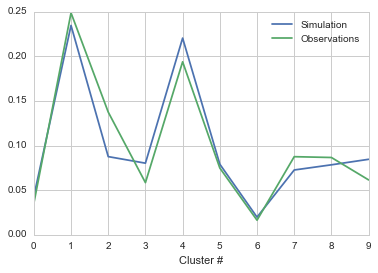

In [6]:
plt.plot(df.groupby('PAT_CLASS')['ID'].count() / len(df), label='Simulation')
plt.plot(obs.groupby('Cluster')['Case'].count() / len(obs), label='Observations')
plt.xlabel('Cluster #')
plt.legend()

# PDFs

Plotting PDFs for LoS in datasets. First, total LoS for simulation.

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


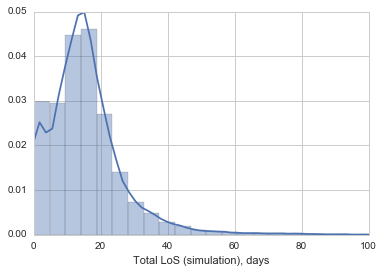

In [7]:
los = np.array(df.groupby('ID')['TIME'].max() - df.groupby('ID')['TIME'].min(), dtype=int)
los = los / (60.0 * 24.0)
sns.distplot(los)
plt.xlim((0,100))
plt.xlabel('Total LoS (simulation), days')

Total LoS for observations

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


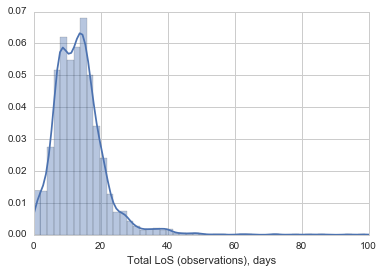

In [8]:
los_obs = obs.LoS / (60.0 * 24.0)
sns.distplot(los_obs[los_obs < 100])
plt.xlim((0,100))
plt.xlabel('Total LoS (observations), days')

Total LoS from conclusion in EHR.

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


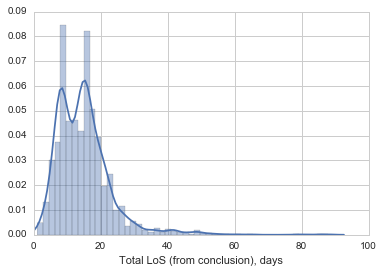

In [9]:
los_1 = np.loadtxt('d:\\Src\\health-des\\data\\acs\\los.txt').flatten()
los_1 = los_1[los_1 < 100]
sns.distplot(los_1)
plt.xlim((0,100))
plt.xlabel('Total LoS (from conclusion), days')

LoS for selected state and patient class in simulation and observation datasets.

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


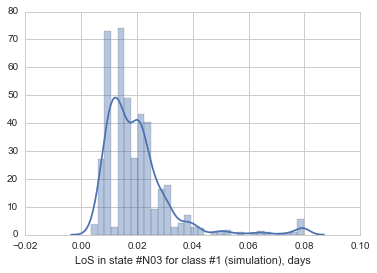

In [10]:
sel_state = 'N03'
pat_class = 1
def get_sim_res(p_class, state_name):
    gr = df[(df.STATE == state_name) & (df.PAT_CLASS == p_class)].groupby('ID')['TIME']
    return np.array(gr.max() - gr.min()) / (60.0 * 24.0)
state_sim_los = get_sim_res(pat_class, sel_state)
sns.distplot(state_sim_los)
# plt.xlim((0, 100))
plt.xlabel('LoS in state #' + sel_state + ' for class #' + str(pat_class) + ' (simulation), days')

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


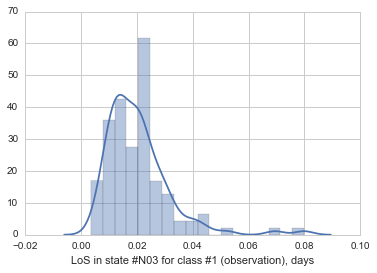

In [11]:
def get_obs_res(p_class, state_name):
    f = open('d:\\Src\\health-des\\data\\acs\\Distr_states_' +str(p_class) + '\\' + state_name + '.txt')
    f.readline()
    s = f.readline()
    f.close()
    return np.array([float(ss) for ss in s[1:-2].split(', ')]) / (60.0 * 24.0)
state_obs_los = get_obs_res(pat_class, sel_state)
sns.distplot(state_obs_los)
# plt.xlim((0, 1))
plt.xlabel('LoS in state #' + sel_state + ' for class #' + str(pat_class) + ' (observation), days')

QQ-plot for selected state

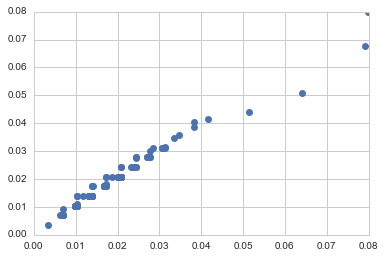

In [12]:
pp = np.arange(0, 101, 1)
plt.plot(np.percentile(state_sim_los, pp), np.percentile(state_obs_los, pp), 'o')
# plt.xlim((0, 100))
# plt.ylim((0, 100))

Counting p-values for states and classes using KS test.

In [13]:
class_ids = np.arange(0,10)
states_ids = []
for cid in class_ids:
    f = open('d:\\Src\\health-des\\data\\acs\\Transition_matrix' + str(cid) + '.csv')
    s = f.readline()
    f.close()
    s = s.replace(';*01;', '').replace(';_01\n', '')
    states_ids = states_ids + s.split(';')
states_ids = list(set(states_ids))
states_ids.sort()
p_v = pd.DataFrame(index=states_ids)
for cid in class_ids:
    f = open('d:\\Src\\health-des\\data\\acs\\Transition_matrix' + str(cid) + '.csv')
    s = f.readline()
    f.close()
    s = s.replace(';*01;', '').replace(';_01\n', '')
    c_st_ids = s.split(';')
    dct = {}
    for st_id in c_st_ids:
        t_state_sim_los = get_sim_res(cid, st_id)
        t_state_obs_los = get_obs_res(cid, st_id)
        dct[st_id] = scipy.stats.ks_2samp(t_state_sim_los, t_state_obs_los).pvalue
    dct_df = pd.DataFrame.from_dict(dct, orient='index')
    dct_df.columns = ['C' + str(cid)]
    p_v = pd.concat([p_v, dct_df], axis=1)
print('P-VALUES FOR LOS IN STATES\n' + p_v.to_string(float_format=lambda f: '%2.2f' % f))

P-VALUES FOR LOS IN STATES
      C0   C1   C2   C3   C4   C5   C6   C7   C8   C9
A00 0.95 1.00 0.55 0.54 0.81 0.10 0.96 0.59 0.82 1.00
D01  nan  nan 0.99  nan  nan  nan  nan  nan 0.63  nan
D07  nan  nan  nan  nan 1.00  nan  nan 0.99  nan 0.32
D08  nan 0.66  nan  nan  nan  nan  nan  nan  nan  nan
D09  nan  nan 0.00  nan  nan  nan  nan  nan  nan  nan
D12  nan  nan  nan  nan  nan  nan  nan  nan 0.72  nan
D15 0.99  nan  nan 0.92  nan 0.81 0.78  nan  nan  nan
E01  nan  nan  nan  nan  nan  nan  nan 0.71  nan  nan
E02 0.96  nan 0.95 0.97  nan 1.00 0.96  nan  nan  nan
E04 1.00  nan  nan 0.96  nan 0.74  nan  nan 1.00  nan
E06  nan  nan  nan  nan 0.10  nan  nan 0.15 0.71 0.99
E07  nan 0.41  nan  nan  nan  nan  nan  nan  nan  nan
E08  nan  nan 0.07  nan  nan  nan  nan 0.51  nan 0.58
E09 0.78 0.98  nan 0.97  nan 0.88 0.92  nan  nan  nan
E10  nan  nan 1.00  nan  nan  nan  nan  nan  nan  nan
E11  nan  nan  nan  nan  nan  nan  nan  nan 1.00  nan
E13  nan  nan  nan  nan  nan  nan  nan  nan 1.00  nan
E

Selecting top classes for QQ plots. Plottin QQ-plots for selected classes and all patients.

In [16]:
ser = df.groupby('PAT_CLASS', sort=True)['ID'].count()
cid_counter = ser.sort_values(ascending=False)
top_cid = np.array(cid_counter.index[0:3])
cid_counter, top_cid

(PAT_CLASS
 1    43894
 4    41245
 2    16394
 9    15830
 3    15019
 5    14802
 8    14675
 7    13590
 0     8055
 6     3700
 Name: ID, dtype: int64, array([1, 4, 2], dtype=int64))

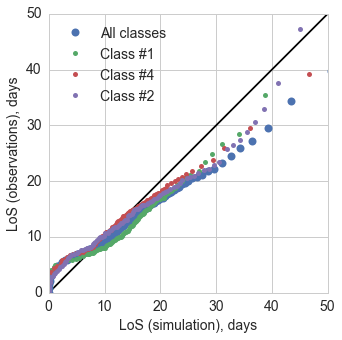

In [17]:
lims = (0,50)
plt.figure(figsize=(5,5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(lims, lims, 'k-')
los_sim = np.array(df.groupby('ID')['TIME'].max() - df.groupby('ID')['TIME'].min()) / (60.0*24.0)
los_obs = np.array(obs['LoS']) / (60.0*24.0)
plt.plot(np.percentile(los_sim, pp), np.percentile(los_obs, pp), 'o', markersize=8, label='All classes')
for cid in top_cid:
    df_sel = df[df.PAT_CLASS == cid]
    los_sim = np.array(df_sel.groupby('ID')['TIME'].max() - df_sel.groupby('ID')['TIME'].min()) / (60.0*24.0)
    los_obs = np.array(obs[obs.Cluster == cid]['LoS']) / (60.0*24.0)
    plt.plot(np.percentile(los_sim, pp), np.percentile(los_obs, pp), 'o', markersize=5, label='Class #'+str(cid))
plt.xlim((0, 50))
plt.ylim((0, 50))
plt.xlabel('LoS (simulation), days', fontsize=14)
plt.ylabel('LoS (observations), days', fontsize=14)
plt.gca().set_aspect('equal')
plt.legend(loc=2, fontsize=14)

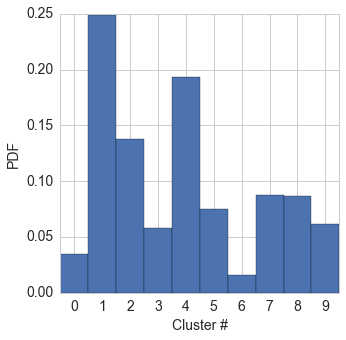

In [29]:
ser = obs.groupby('Cluster', sort=True)['Case'].count()
idx = ser.index
v = np.array(ser)
v = v / v.sum()
plt.figure(figsize=(5,5))
plt.yticks(fontsize=14)
plt.bar(idx, v, width=1)
plt.xticks(idx + 0.5, idx, fontsize=14)
plt.xlim((0, 10))
plt.xlabel('Cluster #', fontsize=14)
plt.ylabel('PDF', fontsize=14)